# Theis and Hantush type curves (timing the functions)

Here we do some testing of Theis and Hantush well function computations using a variety if implementations in Python.

We have implemented 4 variants of the Theis well functions and four variants of the Hantush well function compared them and timed time.

While we can directly use `scipy.special.exp1` for the Theis well function, there is no function in `scipy.special` for the equivalent Hantush wellf function. That's why we have to integrate it ourselves. Be most straight forward and in fact best way is to integrate the kernal of the formula numerically and for that use the `scipy.integrate.quad` method, as it is fast, stable and at least 10 didgets accurate.

Ed J.M. Veling in has warned that accurate computation of Hantush is essential for many applications and has shown in a paper how to to accurately compute it. In this notebook we explore some implementations of the function and test their performance.

@TO 2020-12-14

# Theis and Hantush well functions


## Theis well function ($\mbox{W(}u)$)

$$s(r, t) = \frac{Q_0} {4 \pi kD} W_{theis}(u),\,\,\,\,\,u=\frac{r^2 S }{4 kD t}$$

The Theis well function is mathematically known as the exponential integral or $\mbox{expint}(z)$. In Python this function is avaialble in the `scipy.special` module as `exp1`. So you import it as

    from scipy.special import exp1

or

    from scipy.special import exp1 as Wth

This renames exp1 to Wth, if you should prefer it.

$$ W_{theis} = \mbox{expint}(u) = \mbox{scipy.special.exp1}(u)$$

There exist two mathematical formulaa for the exponential integral

$$W(u) = exp1(u) = \mbox{expint}(u) = \intop_u^\infty \frac{e^{-y}} y dy$$

Then there is the power series form:

$$\mbox{expint}(u) = \sum_0^\infty\left[-\gamma - \ln u + u -\frac{u^2}{2 \times 2!}
+\frac{u^3}{3 \times 3!} - \frac{u^4}{4 \times 4!} - ...\right],\,\,\,\,\,\gamma=0.577216...$$

The $\gamma$ is so-called Euler's constant, a basic math constant like $e$, $\pi$ etc.

The second, power series form of Theis's well function comes in very handy for understanding the function's behavior and straight-forward analysis of pumping tests for wells in confined and unconfined aquifers that show `Theis` behavior, by which we mean, there is no equilibrium ever, because all the extractd water originates from storage in the aquifer only.

# Hantush's well function ($\mbox{Wh}(u, \rho)$).

Hantush considers transient drawdown due to a well well in a semie-confined aquifer. Hence there is an drawdwown-induced infiltration from an adjacent layer, in which the head is assumed constant. This means that extrated water comes not only from storage (which is the case initially) but also from this induced infiltration. After longer times the full extraction originates from this induced infiltration, due to which the drawdown becomes stationary. But in very early times, the drawdown of the Theis and Hantush wells are the same. So, also the mathematical form of the Hantush solution resembles that of the Theis solution.

$$s(r, t) = \frac {Q_0}{4 \pi kD} Wh(u, \rho),\,\,\,\,\,u=\frac{r^2 S}{4 kD t}, \,\,\,\rho = \frac r \lambda$$

where $\lambda = \sqrt{kD c}$.

Like it is the case with the Theis well function, the Hantush well function can be written as an definite integral

$$W_h(u,\rho) = \intop_u^\infty \frac{e^{-y -\frac{\left(\frac{\rho}{2}\right)^2}{y} }}{y} dy$$

The Hantush well function may also be computed as a power series:

$$ W_h(u, \rho) = \sum_{n=0}^{\infty}\frac {-1^n} {n!} \left( \frac \rho 2 \right)^{2n} u^{-n} E_{n+1}\left(\frac {\rho^2} {4 u} \right) $$

$$ E_{n+1} = \frac 1 n \left[ e^{-u} - u E_n (u) \right] , \,\,(n=1, 2, 3, ...) $$

In which $E_i$ is the ith repeated integral of the exponential function and $E_1 = \mbox{expint}$.

Four methods are implemented below. But in conclusion, just stay with the one using the quad as it is fast enough and extremely accurate.

# Import required functionality

In [41]:
import numpy as np
from scipy.integrate import quad
from scipy.special import exp1
import matplotlib.pyplot as plt
from timeit import timeit
import pdb



def newfig(title=None, xlabel=None, ylabel=None,
                           xscale=None, yscale=None, xlim=None, ylim=None, figsize=(12, 6), size=10):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    ax.set_title(title, size=size)
    ax.set_xlabel(xlabel, size=size)
    ax.set_ylabel(ylabel, size=size)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)        
    ax.grid()
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    return ax



# Handy for object inspection:
attribs = lambda obj: [o for o in dir(obj) if not o.startswith('_')]

def clrs():
    colors = 'brgkmc'
    for i in range(100):
        yield colors[i % len(colors)]

## Two variant implementations of the Theis well fuction

    W_theis0: exp1 directly from scipy.special
    W_theis1: by integration using scipy and numpy functionality.


In [3]:
def W_theis0(u):
    """Return Theis well function using scipy.special function exp1 directly."""
    return exp1(u)

In [13]:
def W_theis1(u):
    """Return Theis well function by integrating using scipy functionality.
    
    This turns out to be a very accurate yet fast impementation, about as fast
    as the exp1 function form scipy.special.
    
    In fact we define three functions and finally compute the desired answer
    with the last one. The three functions are nicely packages in the overall
    W_theis1 function.
    """

    def funcTh(y): return np.exp(-y)  / y

    def Wth2(u): return quad(funcTh, u, np.inf)

    WTh = np.frompyfunc(Wth2, 1, 2)
    
    return WTh(u)

In [5]:
def W_theis2(u, practically_log_inf=20, steps_per_log_cycle=50):
    """Theis well function using smart integration"""
    if np.isscalar(u):
        u = np.array([u])
    # Genereate integration point from first u tot practially inf and mix with the 
    # given u, so they are in the array of u values.
    lu0 = np.log10(u[0])
    n = int((practically_log_inf - lu0) * steps_per_log_cycle)
    uu = np.unique(np.hstack((np.logspace(lu0, practically_log_inf, n), u)))
    kernel = np.exp(-uu)
    dlnu = np.diff(np.log(uu))
    Wuu = np.cumsum(np.hstack((0, (kernel[:-1] + kernel[1:]) * dlnu / 2)))
    Wuu = Wuu[-1] - Wuu # This holds the integral from each uu to infinity
    # So now just look up the Wuu values where uu is u
    W = np.zeros_like(u)
    for i, ui in enumerate(u):
        W[i] = Wuu[np.where(uu==ui)[0][0]]
    return W

In [6]:
def W_theis3(u):
    """Return Theis well function using power series."""
    tol = 1e-16
    gam = 0.577216

    if np.isscalar(u):
        u = np.array([u])
    u1 = u[u <= 15] # All outcomes for u > 15 are identical to zero
    terms0 = u1
    W = -gam - np.log(u1) + terms0
    for i in range(2, 250):
        terms1 = -terms0 * u1 * (i -1) / (i * i)
        W += terms1
        if np.max(np.abs(terms0 + terms1)) < tol:
            break
        terms0 = terms1
    return np.hstack((W, np.zeros_like(u[u > 15])))

## Four variant implementations of the Hantush well function

In [7]:
def W_hantush0(u=None, rho=None):
    """Return Hantush well function computed as a power series."""
    w    = 0.
    r2u  = (rho/2) ** 2 / u
    term = exp1(r2u)
    E0   = exp1(r2u)
    w    = term
    for n in range(1, 11):
        E1 = (1/n) * (np.exp(-r2u) - r2u * E0)
        term = term * (-1)/(n+1) * (rho/2) ** 2 / u * E1/E0
        w += term
        E0 = E1
    return w

In [8]:
def W_hantush1(u, rho):
    """Return Hantush well function by straight-forward integration.
    
    A large number of points are required to be accurate, but it won't
    still be as accurate as the quad method from scipy.integrate which is
    also at least as fast.
    
    """
    if np.isscalar(u):
        u = np.asarray([u])

    w = np.zeros_like(u)
    for i, uu in enumerate(u):
        y = np.logspace(np.log10(uu), 10, 5000)
        arg = np.exp(-y - (rho/2) ** 2 / y ) / y
        w[i] = np.sum(np.diff(y) * 0.5 * (arg[:-1]+ arg[1:]))
    return w

In [9]:
def W_hantush2(u, rho):
    """Return Hantush well function by integration trying to be smarter.
    
    This function is no faster than the previous one with 5000 points.
    
    Parameters
    ----------
    u = np.ndarray of floats
        an array of u values u = r**2 S  / (4 kD t)
    rho: float
        value of r/lambda with lambda = sqrt(kD c)    
    """
    if np.isscalar(u):
        u = np.asarray([u])
    uu = np.unique(np.hstack((np.logspace(np.log10(np.min(u)), 10, 5000), u)))
    arg  = np.exp(-uu - (rho/2) ** 2 / uu) / uu
    duu = np.diff(uu)
    S = np.hstack((0, (arg[1:] + arg[:-1])* duu / 2))
    Wsum = np.zeros_like(u)
    for i, ui in enumerate(u):
        Wsum[i] = np.sum(S[uu > ui])
    return Wsum

In [10]:
def W_hantush3(u, rho):
    """Return Hantush well function by integration using scipy functinality.
    
    This is efficient and accurate to 1e-9, which the other direct integration
    methods don't achieve, even with 5000 points.
    
    
    """
    def whkernel(y, rho): return np.exp(-y - (rho/2) ** 2 / y ) / y    

    def whquad(u, rho): return quad(whkernel, u, np.inf, args=(rho))

    Wh = np.frompyfunc(whquad, 2, 2) # 2 inputs and tow outputs h and err
    
    return Wh(u, rho)[0] # cut-off err

# Timing the functions

In [14]:
u  = np.logspace(-3, 1, 41)
rho = 0.003

theis_funcs = [W_theis0, W_theis1, W_theis2, W_theis3]
hantush_funcs = [W_hantush0, W_hantush1, W_hantush2, W_hantush3]

for i, f in enumerate(theis_funcs):
    print(f'W_theis{i}: ', f(u)[:3])
    
for i, f in enumerate(hantush_funcs):
    print(f'W_hantush{i}: ',f(u, rho)[:3])

W_theis0:  [6.33153936 6.10153963 5.87160686]
W_theis1:  (array([6.331539364136134, 6.1015396340805, 5.871606860923733,
       5.641758353670541, 5.412015886801196, 5.182406846999509,
       4.952965671259413, 4.723735648592408, 4.494771174389317,
       4.266140566601892, 4.037929576538092, 3.810245754162041,
       3.583223857766619, 3.3570325291931633, 3.131882485233772,
       2.9080364976479296, 2.685821438366191, 2.465642636574298,
       2.2480007046966897, 2.0335108017562353, 1.8229239584193715,
       1.6171495101464703, 1.4172767739069076, 1.224592749376965,
       1.0405907374165644, 0.8669623495120133, 0.7055626649455886,
       0.5583359679534082, 0.4271890160615279, 0.31380262938701164,
       0.21938393439551238, 0.14438396227957934, 0.08823821066649554,
       0.049222240819489234, 0.024527866715598656, 0.010625612440848592,
       0.0038670571598556952, 0.0011324099703003741,
       0.00025269640844759807, 4.0121163727726775e-05,
       4.156968930236943e-06], dtype=ob

In [15]:
print('W_theis0 :')
%timeit W_theis0(u)
print('W_theis1(u) :')
%timeit W_theis1(u)
print('W_theis2(u) :')
%timeit W_theis2(u)
print('W_theis3(u) :')
%timeit W_theis3(u)

print('W_hantush0(u, rho) :')
%timeit W_hantush0(u, rho)
print('W_hantus1(, rho) :')
%timeit W_hantush1(u, rho)
print('W_hantush2(u, rho) :')
%timeit W_hantush2(u, rho)
print('W_hantush3(u, rho) :')
%timeit W_hantush3(u, rho)

W_theis0 :
6.3 µs ± 143 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
W_theis1(u) :
7.65 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
W_theis2(u) :
312 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
W_theis3(u) :
537 µs ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
W_hantush0(u, rho) :
87.4 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
W_hantus1(, rho) :
8.53 ms ± 295 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
W_hantush2(u, rho) :
957 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
W_hantush3(u, rho) :
9 ms ± 283 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Results of the timing

### Theis:

    W_theis0 :
    6.06 µs ± 261 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
    W_theis1(u) :
    7.11 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
    W_theis2(u) :
    299 µs ± 6.79 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    W_theis3(u) :
    553 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

Their is almost no difference in speed between direcly using exp1 from scipy and integrating numerically using quad. Both are equally accurate.
Thex explicit integration is slow just as the summation.


### Hantush:

    W_hantush0(u, rho) :
    86 µs ± 1.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    W_hantus1(, rho) :
    7.53 ms ± 72.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    W_hantush2(u, rho) :
    882 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    W_hantush3(u, rho) :
    8.64 ms ± 75.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Note that my "smart" integration (`W_hantush2`) is about 9 time faster than the simple integration and th quad solution. So it turns aout to be smart enough after all.

The smart and normal integration methods are equally accurate to 5 didgets with 5000 points and haveing 1e10 as upper limit. The quad method has 10 didgets accuracy.

The series method is the slowest of all, 10 times slower than the quad and simple integration methods and 100 times slower than my smart method.

The series method is also not accurate. The number of terms to include must be
much larger, which would make it even slower te compute.

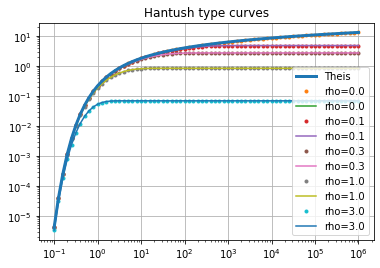

In [16]:
rhos = [0., 0.1, 0.3, 1, 3]

u = np.logspace(-6, 1, 71)

plt.title('Hantush type curves')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.plot(1/u, W_theis0(u), lw=3, label='Theis', zorder=100)
for rho in rhos:
    plt.plot(1/u, W_hantush2(u, rho), '.', label='rho={:.1f}'.format(rho))
    plt.plot(1/u, W_hantush3(u, rho), label='rho={:.1f}'.format(rho))
plt.legend()
plt.show()

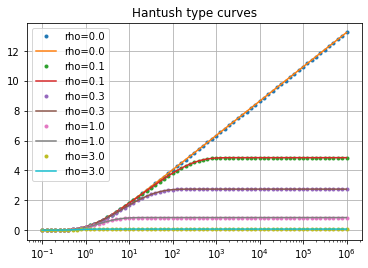

In [237]:
rhos = [0., 0.1, 0.3, 1, 3]

u = np.logspace(-6, 1, 71)

plt.title('Hantush type curves')
plt.xscale('log')
plt.yscale('linear')
plt.grid()
for rho in rhos:
    plt.plot(1/u, W_hantush2(u, rho), '.', label='rho={:.1f}'.format(rho))
    plt.plot(1/u, W_hantush3(u, rho), label='rho={:.1f}'.format(rho))    
plt.legend()
plt.show()

# The inflection point of the Hantush graphs, where $u=r/(2\lambda)=\rho/2$

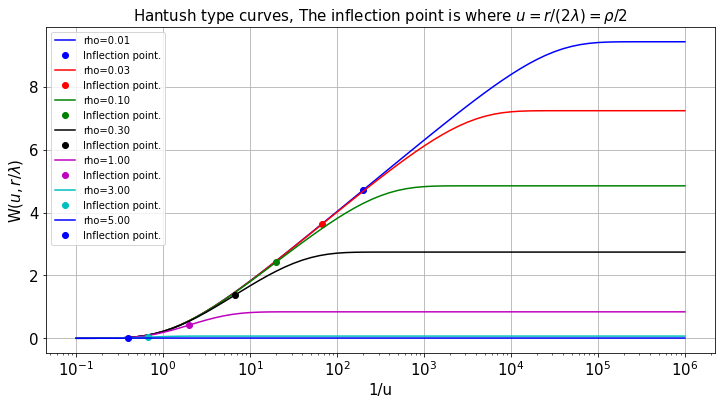

In [44]:
rhos = [0.01, 0.03, 0.1, 0.3, 1, 3, 5]

s = r"The inflection point is where $u = r/(2 \lambda) = \rho/2$"

u = np.logspace(-6, 1, 71)

ax = newfig('Hantush type curves, ' + s, "1/u", r"W($u, r/\lambda$)", xscale='log', figsize=(12, 6), size=15)

for rho, clr in zip(rhos, clrs()):
    ax.plot(1/u, W_hantush3(u, rho), color=clr, label='rho={:.2f}'.format(rho))  
    ax.plot(2/rho, W_hantush3(rho/2, rho), 'o', color=clr, label="Inflection point.")
ax.legend()
plt.show()